# Pokémon Image Classifier Notebook

This notebook guides you through the process of downloading the Pokémon dataset, training a classification model, evaluating its performance, and performing inference on sample images. The key steps include:

1. **Setup and Imports**
2. **Downloading and Organizing the Dataset**
3. **Data Loading and Preprocessing**
4. **Model Initialization**
5. **Training the Model**
6. **Visualizing Training Metrics**
7. **Model Evaluation and Confusion Matrix**
8. **Inference on Sample Images**


## 1. Setup and Imports

First, let's import all the necessary libraries and set up the environment.


In [1]:
import logging
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import classification_report, confusion_matrix
from timm.data import Mixup  # New: Using Mixup from timm
from torch import cuda, device, nn, optim
from torch.amp import GradScaler
from torch.utils.data import DataLoader
from tqdm import tqdm

from download_dataset import main as download_dataset
from src.data.data_loader import load_data
from src.utils.helpers import save_checkpoint
from src.utils.metrics import MetricsCalculator
from src.visualization.tensorboard_logger import TensorBoardLogger
from train import (
    initialize_model,
    initialize_optimizer,
    initialize_scheduler,
    load_config,
    train_epoch,
)

# Ensure plots are displayed inline
%matplotlib inline

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Check for GPU
device = device("cuda" if cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

# Free cuda memory
if cuda.is_available():
    cuda.empty_cache()
    import gc
    gc.collect()
    


/home/joeli/.conda/envs/kantodex-classifier/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-18 11:21:16,300 - INFO - Using device: cuda


## 2. Downloading and Organizing the Dataset

We'll use the provided `download_dataset.py` logic to download and organize the Pokémon dataset. Ensure you have your Kaggle API credentials set up in the .env file before running the following cell.


In [ ]:


if not os.path.exists("data"):
    os.makedirs("data")

# Check if the data has already been downloaded and if not, download it
if not os.path.exists("data/raw"):
    download_dataset(
        dataset_name="bhawks/pokemon-generation-one-22k",
        raw_path="data/raw",
        processed_path="data/processed",
        extra_path="PokemonData",
    )
    download_dataset(
        dataset_name="thedagger/pokemon-generation-one",
        raw_path="data/raw",
        processed_path="data/processed",
        extra_path="dataset",
        skip_folders=[
            "Nidorina",
            "Nidorino",
        ],  # Skip these folders since nidoran-f and nidoran-m are accidentally in these folders
    )
    download_dataset(
        dataset_name="mikoajkolman/pokemon-images-first-generation17000-files",
        raw_path="data/raw",
        processed_path="data/processed",
        extra_path="pokemon",
        skip_folders=[
            "Nidorina",
            "Nidorino",
        ],  # Skip these folders since nidoran-f and nidoran-m are accidentally in these folders
    )
else:
    logging.info("Data already downloaded")


## 3. Data Loading, preprocessing, and setup


In [3]:
# Load the configuration file
config = load_config("src/config/config.yaml")

2024-12-18 11:21:16,425 - INFO - Configuration loaded from src/config/config.yaml


In [4]:
# Load dummy data to get number of classes
_, val_loader_dummy, label_to_idx_dummy = load_data(
    processed_path=config["data"]["processed_path"],
    test_size=config["data"]["test_size"],
    batch_size=1,
    img_size=tuple(config["data"]["img_size"]),
    num_workers=config["data"]["num_workers"],
)
num_classes = len(label_to_idx_dummy)
logging.info(f"Number of classes: {num_classes}")

# Initialize model
model = initialize_model(config, num_classes, device)

# Enable tensorboard logging


tensorboard_logger = TensorBoardLogger(
    log_dir="runs/",
    enabled=True,
)

sample_images, _ = next(iter(val_loader_dummy))
sample_images = sample_images.to(device)
tensorboard_logger.add_graph(model, sample_images)


# Load actual train and val loaders
train_loader, val_loader, label_to_idx = load_data(
    processed_path=config["data"]["processed_path"],
    test_size=config["data"]["test_size"],
    batch_size=config["training"].get("batch_size", 32),
    img_size=tuple(config["data"]["img_size"]),
    num_workers=config["data"]["num_workers"],
)
idx_to_label = {v: k for k, v in label_to_idx.items()}

# Initialize optimizer and scheduler
optimizer = initialize_optimizer(config, model)
scheduler = initialize_scheduler(config, optimizer)

# Initialize loss function
 # Loss with Label Smoothing or FocalLoss with class weights
label_smoothing = config["training"].get("label_smoothing", 0.0)
if label_smoothing > 0.0:
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    logging.info(f"Using CrossEntropyLoss with label smoothing: {label_smoothing}")
else:
    criterion = nn.CrossEntropyLoss()
    logging.info("Using CrossEntropyLoss")


# Metrics
metrics_calculator = MetricsCalculator(num_classes=num_classes)
# Mixed Precision Scaler
scaler = GradScaler(enabled=device.type == "cuda")
# Early Stopping parameters
early_stopping_patience = config["training"].get("early_stopping_patience", 10)
epochs_no_improve = 0
best_accuracy = 0.0

# Mixup initialization if needed
use_mixup = config["augmentation"].get("use_mixup", False)
use_cutmix = config["augmentation"].get("use_cutmix", False)
mixup_fn = None
if use_mixup or use_cutmix:
    # timm Mixup handles both based on provided arguments
    mixup_fn = Mixup(
        mixup_alpha=config["augmentation"].get("alpha", 1.0) if use_mixup else 0.0,
        cutmix_alpha=config["augmentation"].get("alpha", 1.0) if use_cutmix else 0.0,
        label_smoothing=label_smoothing,
        num_classes=num_classes,
    )
    logging.info("Using Mixup/CutMix from timm.")

2024-12-18 11:21:16,500 - INFO - Loaded 19172 training samples and 4793 validation samples.
2024-12-18 11:21:16,501 - INFO - Number of classes: 151
2024-12-18 11:21:16,501 - INFO - Number of classes: 151
2024-12-18 11:21:16,877 - INFO - Initialized model: custom


TensorBoard logging enabled. Logs will be saved to runs/


2024-12-18 11:21:17,839 - INFO - Loaded 19172 training samples and 4793 validation samples.
2024-12-18 11:21:17,840 - INFO - Number of classes: 151
2024-12-18 11:21:17,841 - INFO - Initialized AdamW optimizer.
/home/joeli/.conda/envs/kantodex-classifier/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2024-12-18 11:21:17,842 - INFO - Initialized ReduceLROnPlateau scheduler.
2024-12-18 11:21:17,842 - INFO - Scheduler 'reduce_lr_on_plateau' has been initialized.
2024-12-18 11:21:17,842 - INFO - Using CrossEntropyLoss with label smoothing: 0.1
2024-12-18 11:21:17,853 - INFO - Using Mixup/CutMix from timm.


## 4. Training the Model

In [5]:

def validate(  # noqa: PLR0913
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    device: device,
    metrics_calculator: MetricsCalculator,
    tensorboard_logger: TensorBoardLogger | None = None,
    epoch: int = 0,
    idx_to_label: dict[int, str] | None = None,
) ->tuple[float, float]:
    """
    Validate the model on the validation dataset.

    Args:
        model (nn.Module): The model to validate.
        dataloader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to perform validation on (CPU or CUDA).
        metrics_calculator (MetricsCalculator): Instance to calculate validation metrics.
        tensorboard_logger (Optional[TensorBoardLogger], optional): Logger for TensorBoard.
            Default is `None`.
        epoch (int, optional): Current epoch number for logging purposes. Default is `0`.
        idx_to_label (Optional[dict[int, str]], optional): Dictionary mapping label indices to
            class names. Default is `None`.

    Returns:
        tuple[float, float]: Tuple containing the average validation loss and the validation
            accuracy.

    """
    model.eval()
    metrics_calculator.reset()

    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation", unit="batch"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            metrics_calculator.update(outputs, labels)

    avg_val_loss = running_val_loss / len(dataloader)
    metrics = metrics_calculator.compute()

    if tensorboard_logger:
        epoch_val_accuracy = metrics.get("accuracy", 0.0)
        precision = metrics.get("precision", 0.0)
        recall = metrics.get("recall", 0.0)
        f1_score = metrics.get("f1", 0.0)
        auroc_score = metrics.get("auroc", 0.0)

        tensorboard_logger.add_scalar("Epoch Validation Accuracy", epoch_val_accuracy, epoch + 1)
        tensorboard_logger.add_scalar("Epoch Validation Loss", avg_val_loss, epoch + 1)
        tensorboard_logger.add_scalar("Epoch Validation Precision", precision, epoch + 1)
        tensorboard_logger.add_scalar("Epoch Validation Recall", recall, epoch + 1)
        tensorboard_logger.add_scalar("Epoch Validation F1 Score", f1_score, epoch + 1)
        tensorboard_logger.add_scalar("Epoch Validation Auroc score", auroc_score, epoch + 1)

        if idx_to_label:
            tensorboard_logger.add_class_accuracy(
                class_names=idx_to_label,
                class_accuracy=metrics.get("per_class_accuracy", {}),
                global_step=epoch,
            )
            tensorboard_logger.add_confusion_matrix(
                confusion_matrix=metrics.get("confusion_matrix", np.array([])),
                class_names=idx_to_label,
                global_step=epoch,
            )
            worst_performing = metrics.get("worst_performing_classes", [])[:15]
            logging.info(f"Worst performing classes: {worst_performing}")
            tensorboard_logger.add_text(
                "Worst Performing Classes",
                str(worst_performing),
                epoch,
            )
            for idx, acc in metrics.get("per_class_accuracy", {}).items():
                class_name = idx_to_label.get(idx, f"Class_{idx}")
                tensorboard_logger.add_scalar(
                    f"Class Accuracy/{class_name}",
                    acc,
                    epoch,
                )
        logging.info(
            f"Epoch Validation Loss: {avg_val_loss:.4f}, Precision: {precision:.2f}%, "
            f"Recall: {recall:.2f}%, F1 Score: {f1_score:.2f}%, AUROC: {auroc_score:.2f}%",
        )

    return avg_val_loss, metrics.get("accuracy", 0.0)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

precision_scores = []
recall_scores = []
f1_scores = []

learning_rates = []


# Training loop
num_epochs = config["training"].get("epochs", 100)
for epoch in range(0, num_epochs):
    logging.info(f"Starting epoch {epoch + 1}/{num_epochs}")

    train_loss, train_accuracy = train_epoch(
        model=model,
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        scaler=scaler,
        metrics_calculator=metrics_calculator,
        tensorboard_logger=tensorboard_logger,
        mixup_fn=mixup_fn,
        epoch=epoch + 1,
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    logging.info(
        f"Epoch [{epoch + 1}/{num_epochs}], "
        f"Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%",
    )

    metrics = metrics_calculator.compute()
    precision = metrics.get("precision", 0.0)
    recall = metrics.get("recall", 0.0)
    f1_score = metrics.get("f1", 0.0)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1_score)
    logging.info(
        f"Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1 Score: {f1_score:.2f}%",
    )


    if tensorboard_logger:
        tensorboard_logger.add_scalar("Training Precision", precision, epoch + 1)
        tensorboard_logger.add_scalar("Training Recall", recall, epoch + 1)
        tensorboard_logger.add_scalar("Training F1 Score", f1_score, epoch + 1)

    # Scheduler step
    if scheduler:
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(train_loss)
        else:
            scheduler.step()
        current_lr = optimizer.param_groups[0]["lr"]
        logging.info(f"Learning Rate: {current_lr}")
        if tensorboard_logger:
            tensorboard_logger.add_scalar("Training Learning Rate", current_lr, epoch + 1)
        learning_rates.append(current_lr)

    val_loss, val_accuracy = validate(
        model=model,
        dataloader=val_loader,
        criterion=criterion,
        device=device,
        metrics_calculator=metrics_calculator,
        tensorboard_logger=tensorboard_logger,
        epoch=epoch + 1,
        idx_to_label=idx_to_label,
    )
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    logging.info(f"Validation Accuracy: {val_accuracy:.2f}%")

    # Check for best model
    is_best = val_accuracy > best_accuracy
    if is_best:
        best_accuracy = val_accuracy
        epochs_no_improve = 0
        logging.info(f"New best accuracy: {best_accuracy:.2f}%")
        if tensorboard_logger:
            tensorboard_logger.add_scalar("Best Accuracy", best_accuracy, epoch + 1)
    else:
        epochs_no_improve += 1
        logging.info(f"No improvement in validation accuracy for {epochs_no_improve} epoch(s).")

    # Save checkpoint
    checkpoint_dir = Path(config["training"].get("checkpoint_path", "checkpoints"))
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=epoch + 1,
        checkpoint_dir=str(checkpoint_dir),
        scheduler=scheduler,
        scaler=scaler,
        is_best=is_best,
        best_accuracy=best_accuracy,
    )

    if epochs_no_improve >= early_stopping_patience:
        logging.info("Early stopping triggered.")
        break

logging.info("Training complete.")
if tensorboard_logger:
    tensorboard_logger.close()

2024-12-18 11:21:17,870 - INFO - Starting epoch 1/10
Training: 100%|██████████| 320/320 [04:48<00:00,  1.11batch/s]
2024-12-18 11:26:06,466 - INFO - Epoch [1/10], Loss: 4.8979, Accuracy: 5.84%
2024-12-18 11:26:06,467 - INFO - Precision: 3.98%, Recall: 4.25%, F1 Score: 3.83%
2024-12-18 11:26:06,468 - INFO - Learning Rate: 0.0005
Validation: 100%|██████████| 80/80 [00:36<00:00,  2.20batch/s]
2024-12-18 11:26:52,410 - INFO - Worst performing classes: [(0, 0.0), (1, 0.0), (2, 0.0), (5, 0.0), (6, 0.0), (8, 0.0), (13, 0.0), (15, 0.0), (18, 0.0), (23, 0.0), (25, 0.0), (28, 0.0), (29, 0.0), (31, 0.0), (32, 0.0)]
2024-12-18 11:26:52,441 - INFO - Epoch Validation Loss: 3.9339, Precision: 17.39%, Recall: 12.78%, F1 Score: 10.04%, AUROC: 90.63%
2024-12-18 11:26:52,442 - INFO - Validation Accuracy: 15.98%
2024-12-18 11:26:52,442 - INFO - New best accuracy: 15.98%
2024-12-18 11:26:52,717 - INFO - Checkpoint saved at models/checkpoints/checkpoint_epoch_2.pth
2024-12-18 11:26:52,747 - INFO - Removed o

## 5. Visualizing Training Results

Let's plot the training and validation loss and accuracy over epochs.


Train Losses:  []
Val Losses:  [3.9338535755872726, 3.540338319540024, 3.1893672376871107, 2.8352292090654374, 2.7253741979599, 2.63382810652256, 2.4437215492129325, 2.4260797619819643, 2.248150809109211, 2.2363117545843125]
Train Accuracies:  []
Val Accuracies:  [15.981639921665192, 26.037973165512085, 36.19862198829651, 43.50093901157379, 48.737743496894836, 51.36657357215881, 57.0415198802948, 57.771748304367065, 61.44376993179321, 62.94596195220947]
Epochs Range:  range(1, 11)


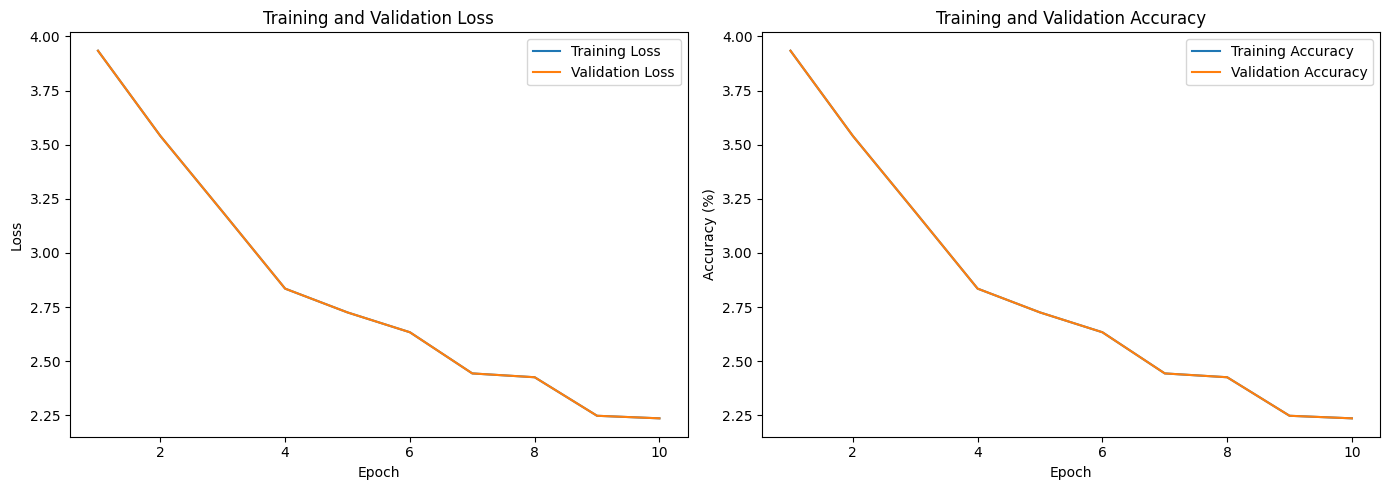

In [ ]:
# Plot Loss and Accuracy
epochs_range = range(1, len(val_losses) + 1)

plt.figure(figsize=(14, 5))

print("Train Losses: ", train_losses)
print("Val Losses: ", val_losses)
print("Train Accuracies: ", train_accuracies)
print("Val Accuracies: ", val_accuracies)
print("Epochs Range: ", epochs_range)

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## 6. Model Evaluation and Confusion Matrix

After training, we'll evaluate the model on the validation set and create a confusion matrix to understand where the model is making mistakes.


/tmp/ipykernel_10889/1403973625.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_dir / "best_model.pth")["model_state_dict"])


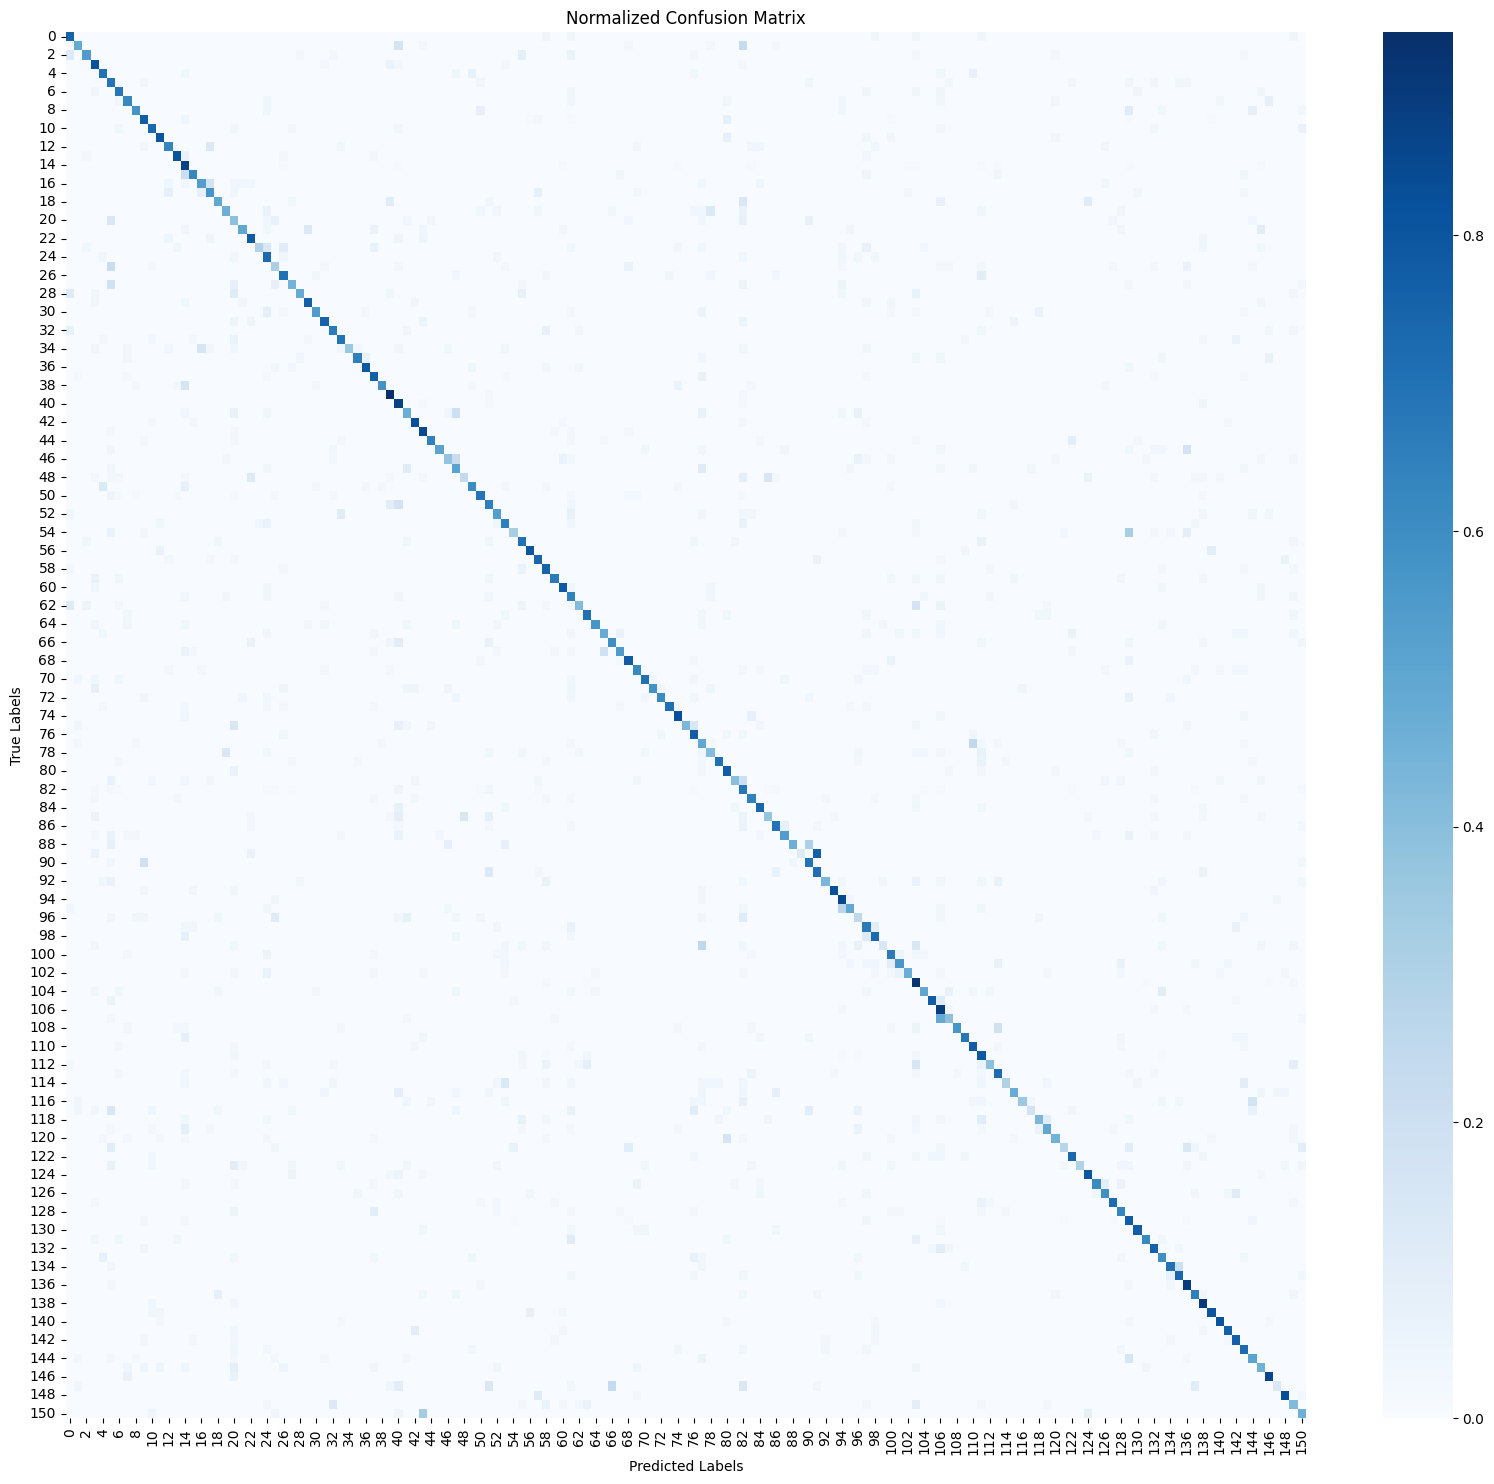

              precision    recall  f1-score   support

        Abra       0.51      0.75      0.61        24
  Aerodactyl       0.68      0.49      0.57        35
    Alakazam       0.78      0.55      0.64        33
       Arbok       0.53      0.82      0.64        33
    Arcanine       0.59      0.70      0.64        27
    Articuno       0.27      0.69      0.39        29
    Beedrill       0.54      0.68      0.60        22
  Bellsprout       0.57      0.62      0.59        26
   Blastoise       0.71      0.58      0.64        26
   Bulbasaur       0.76      0.77      0.77        70
  Butterfree       0.67      0.73      0.70        30
    Caterpie       0.74      0.80      0.77        25
     Chansey       0.73      0.63      0.68        30
   Charizard       0.81      0.81      0.81        31
  Charmander       0.60      0.87      0.71        84
  Charmeleon       0.71      0.62      0.67        24
    Clefable       0.68      0.54      0.60        28
    Clefairy       0.52    

In [17]:
# Load the best model
model.load_state_dict(torch.load(checkpoint_dir / "best_model.pth")["model_state_dict"])
model.eval()

# Collect all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        with torch.amp.autocast(enabled=(device.type == "cuda"), device_type="cuda" if cuda.is_available() else "cpu"):
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
cm_norm = confusion_matrix(all_labels, all_preds, normalize='true')

plt.figure(figsize=(20, 18))
sns.heatmap(cm_norm, annot=False, cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
report = classification_report(all_labels, all_preds, target_names=[idx_to_label[i] for i in range(num_classes)])
print(report)

# Identify most confused classes
def get_most_confused(cm: np.ndarray, idx_to_label: dict[int, str], top_n: int = 10) -> list[tuple[str, str, float]]:
    cm_copy = cm.copy().astype(float)
    np.fill_diagonal(cm_copy, 0)  # Remove correct predictions
    confusions = []
    for i in range(cm_copy.shape[0]):
        for j in range(cm_copy.shape[1]):
            if cm_copy[i, j] > 0:
                confusions.append((idx_to_label[i], idx_to_label[j], cm_copy[i, j]))
    # Sort by highest confusion
    confusions_sorted = sorted(confusions, key=lambda x: x[2], reverse=True)
    return confusions_sorted[:top_n]

most_confused = get_most_confused(cm, idx_to_label, top_n=10)
print("Most Confused Classes:")
for true_label, pred_label, count in most_confused:
    print(f"{true_label} confused with {pred_label}: {count} times")


## 7. Inference on Sample Images

We'll run inference on a subset of validation images and display them with the predicted labels.


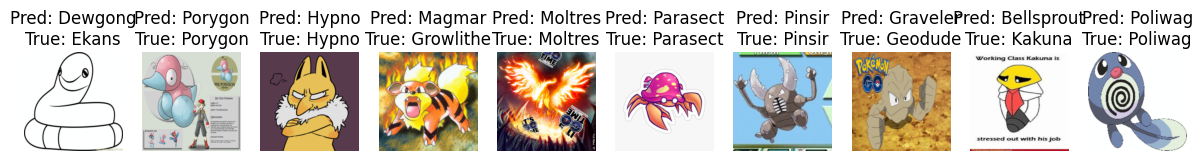

In [18]:
# Function to display images with predictions
def display_predictions(model: nn.Module, dataloader: DataLoader, idx_to_label: dict[int, str], num_images: int = 10):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            with torch.amp.autocast(enabled=(device.type == "cuda"), device_type="cuda" if cuda.is_available() else "cpu"):
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                img = np.clip((img * np.array([0.229, 0.224, 0.225])) +
                              np.array([0.485, 0.456, 0.406]), 0, 1)
                plt.subplot(1, num_images, images_shown + 1)
                plt.imshow(img)
                plt.title(f"Pred: {idx_to_label[predicted[i].item()]}\nTrue: {idx_to_label[labels[i].item()]}")
                plt.axis('off')
                images_shown += 1
            if images_shown >= num_images:
                break
    plt.show()

# Display predictions on 10 validation images
display_predictions(model, val_loader, idx_to_label, num_images=10)
